<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/emprego_pe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro
### Análise de Série Temporal dos estoques do mercado formal em Pernambuco

### Fonte de dados: RAIS e CAGED
Dados da RAIS para os meses de dezembro, para outros meses usamos os fluxos do CAGED que são somados a RAIS.

### Período: após 2013

### Pacotes

In [254]:
# dados
from math import sqrt
import pandas as pd
import numpy as np

In [2]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelação (e (parcial)
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [315]:
# métricas de avaliação

''' 
iremos usar 2 métricas de avaliação
fazer a raiz do erro médio ao quadrado 
(que penaliza grandes desvios) e
o erro médio absoluto
'''

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

### Dataset - Estoques PE

In [5]:
file_estoque = '/content/drive/My Drive/Colab Notebooks/emprego/bases/estoques_pe_.xlsx'
df = pd.read_excel(file_estoque)
df['ano_mes'] = pd.to_datetime(df.ano_mes, format="%Y%m")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ano_mes       115 non-null    datetime64[ns]
 1   Sum(estoque)  115 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


In [7]:
estoque_pe = df.query("ano_mes >= '2013-01-01'") 
estoque_pe.set_index('ano_mes', inplace=True)
estoque_pe.columns = ['estoques']

In [8]:
estoque_pe.index.dtype

dtype('<M8[ns]')

### Analisando a série

Que a partir de 2015, certa estabilidade depois de 2017 até mais uma queda em 2020.

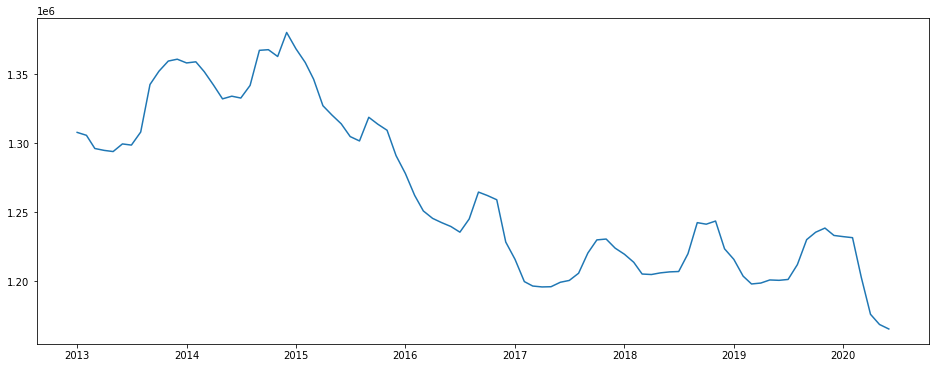

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(estoque_pe);

A queda em 2020 fica mais visível quando damos um zoom nos últimos 3 anos.

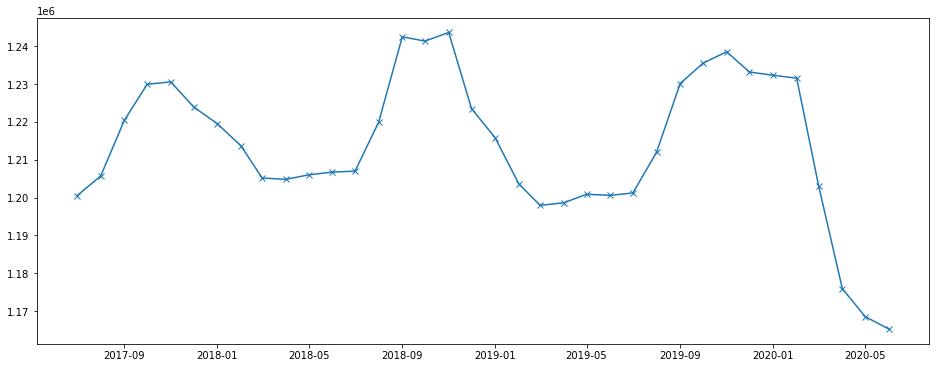

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(estoque_pe.tail(36), 'x-');

Agora vamos decompor toda a série e obter sua tedência, sazonalidade e ruídos.

Fica mais claro a queda pós 2015, agora um breve aumento depois 2018 e meados de 2019. Bastante nítidao também o caráter sazonal da série até 2020. Em virtude da pandemia, observe uma pertubação maior no ruído no fim da série do 4o gráfico.

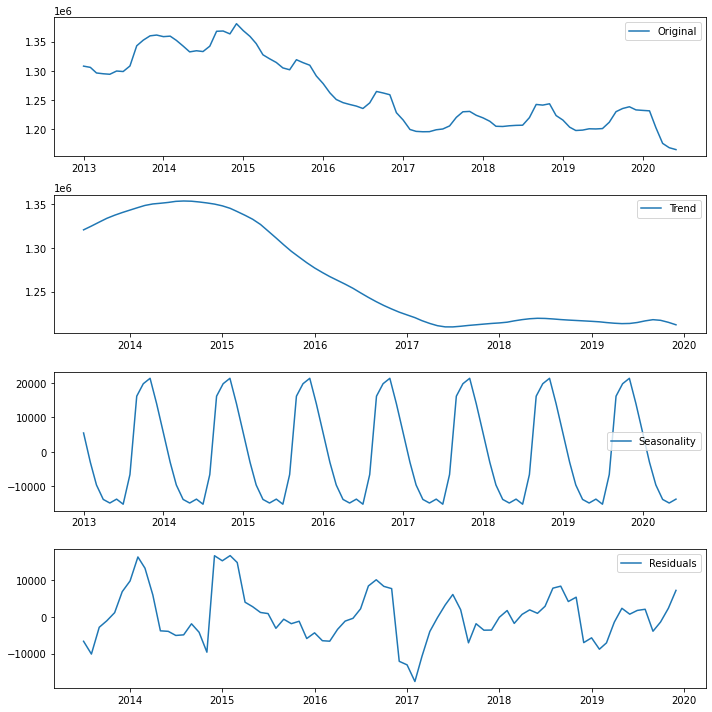

In [11]:
decomp = seasonal_decompose(estoque_pe)
tendencia = decomp.trend
sazonalidade = decomp.seasonal
residuo = decomp.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(estoque_pe, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Dados de treino e teste

Vamos separar a série em 75-25%, treino e teste. Criaremos modelos utlizando os dados de treino para depois avaliarmos sua capacidade de predição com os dados de teste.

In [12]:
n_dados_teste = int(len(estoque_pe) * 0.25)

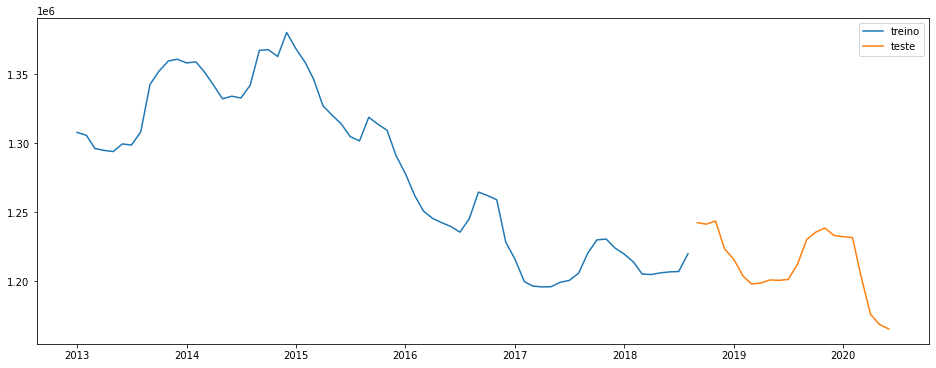

In [13]:
treino, teste = estoque_pe[:-n_dados_teste], estoque_pe[-n_dados_teste:]
plt.figure(figsize=(16, 6))
plt.plot(treino, label='treino')
plt.plot(teste, label = 'teste')
plt.legend(loc= 'best');

In [14]:
print('dados de treino: ', treino.shape[0], 'dados de teste: ', teste.shape[0])

dados de treino:  68 dados de teste:  22


### Teste de estacionaridade

Para modelos que usem ARIMA é preciso tornar a série estacionária para estimar os parâmetros de autoregressão (AR) e média móvel (MA) através dos gráficos de autoregressão e autoregressão parcial. Geralmente uma série se torna estacionária (parâmetro I) com até duas diferenciações. Foi o nosso caso.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


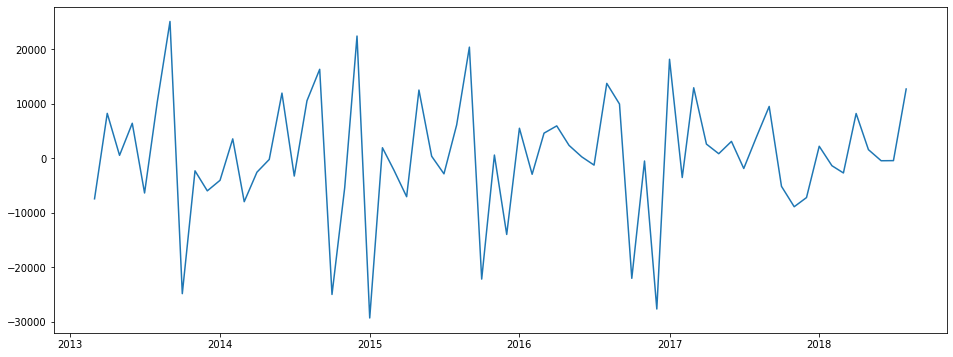

In [15]:
plt.figure(figsize=(16, 6))
treino['log'] = treino.estoques.diff().diff()
plt.plot(treino.log)

In [16]:
def teste_df(serie, valor_critico=10):
    #H0: série não estacionária 
    dftest = adfuller(serie, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nº Observações'])
    for key, value in dftest[4].items():
        df_output['Valor Crítico (%s)'%key] = value
    print(df_output)
    # descarta a H0 se o teste estatistico for menor que o valor crítico 
    if df_output[0] < df_output[f"Valor Crítico ({valor_critico}%)"]: 
        
        print('--------estacionária')
    else:
        print(df_output[0])
        print('--------não estacionária')

In [17]:
teste_df(treino['log'].dropna(), 1)

Test Statistic        -7.183737e+00
p-value                2.609249e-10
#Lags                  1.000000e+01
Nº Observações         5.500000e+01
Valor Crítico (1%)    -3.555273e+00
Valor Crítico (5%)    -2.915731e+00
Valor Crítico (10%)   -2.595670e+00
dtype: float64
--------estacionária


Os testes abaixo apresentaram apenas um lag significativo tanto para autocorrelação (MA) quanto para autocorrelação parcial (AR).

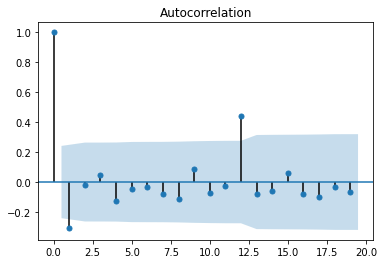

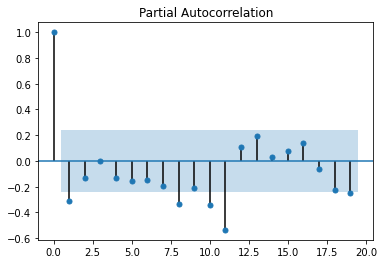

In [18]:
plot_acf(treino['log'].dropna());
plot_pacf(treino['log'].dropna());

## SARIMA

Agora que já temos nossos parâmentros AR I MA, vamos usá-lo numa versão de ARIMA com fator sazonal, o SARIMA.

### Modelo

In [288]:
arima_params = (1, 2, 1)
sarima_params = (*arima_params, 12)

Notório o descompasso entre real e projetado a partir de abril de 2020.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


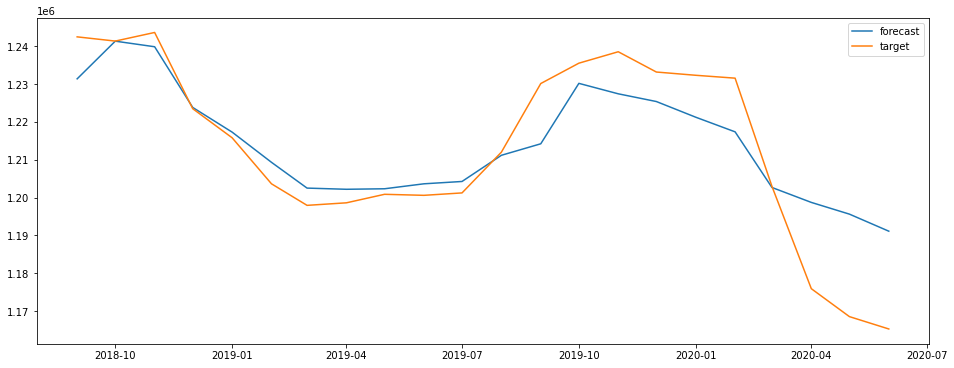

In [328]:
sarima = SARIMAX(
    endog=treino['estoques'], order=arima_params, seasonal_order=(sarima_params),
    enforce_stationarity=False, enforce_invertibility=False, freq='MS')

model_sarima = sarima.fit()

previsao_sarima = model_sarima.forecast(len(teste))

plt.figure(figsize=(16, 6))
plt.plot(previsao_sarima, label = 'forecast')
plt.plot(teste.estoques, label = 'target')
plt.legend()
plt.show()

### Avaliação

De toda série de TESTE

In [329]:
sqrt(mse(teste.estoques, previsao_sarima))

11555.924298719981

In [330]:
mae(teste.estoques, previsao_sarima)

8197.371042072911

Pós 2020

In [292]:
sqrt(mse(teste.loc['2020-01-01':].estoques, previsao_sarima.loc['2020-01-01':]))

19343.31516378939

In [293]:
mae(teste.loc['2020-01-01':].estoques, previsao_sarima.loc['2020-01-01':])

16882.131294419447

### Predições

Utilizando o modelo para todo o dataset e fazendo predições até dez de 2020.

In [294]:
sarima_pred = SARIMAX(
    endog=estoque_pe['estoques'], order=arima_params, seasonal_order=(sarima_params),
    enforce_stationarity=False, enforce_invertibility=False, freq='MS')

model_sarima_pred = sarima_pred.fit()

In [295]:
fcast = model_sarima_pred.predict(
      len(estoque_pe) - 7, 
      len(estoque_pe) + 5).rename('Forecast')

In [296]:
fcast.diff()

2019-12-01             NaN
2020-01-01     3262.083154
2020-02-01    -2742.287207
2020-03-01     1289.630885
2020-04-01   -31187.517478
2020-05-01   -42710.195692
2020-06-01    -8875.757622
2020-07-01    12058.389601
2020-08-01    10331.548728
2020-09-01    15644.040003
2020-10-01    -2914.758798
2020-11-01     -673.887437
2020-12-01   -12068.505464
Freq: MS, Name: Forecast, dtype: float64

O 2o semestre teria o saldo abaixo:

In [297]:
fcast.loc['2020-06-01':].diff().sum()

22376.826634083176

## SARIMAX utilizando Índice de Atividade Econômica

Trata-se  de  indicador  de periodicidade  mensal,  que  incorpora  variáveis  consideradas  como proxies para  desempenho dos setores da economia - estimativas de crescimento para os setores agropecuário, industrial e de serviços, acrescidas dos impostos sobre produtos, que são estimados a partir da evolução da oferta total (produção + importações).

Vamos usar como variável exógena para composição do modelo, agora nosso SARIMA se torna SARIMAX.

### Dataset Ibc

In [298]:
file_ibcpe = '/content/drive/My Drive/Colab Notebooks/emprego/bases/IBCR-PE.csv'
ibc = pd.read_csv(file_ibcpe, sep=';', dtype={'data': 'str', 'indice':'float', 'indice_ajus':'float'}, decimal=',')
ibc['data'] = pd.to_datetime(ibc.data, format="%m/%Y")
ibc.set_index('data', inplace=True)
ibc = ibc.loc['2013-01-01':]

In [299]:
ibc_junho = pd.DataFrame(ibc.tail().mean()).T
ibc_junho['data'] = pd.to_datetime('2020-06-01')
ibc_junho.set_index('data', inplace=True)
ibc_junho.head()

,indice,indice_ajus
data,,
2020-06-01,135.05,139.744


In [300]:
ibc_teste_atualiz = pd.concat([ibc, ibc_junho], axis=0)
ibc_teste_atualiz.tail()

,indice,indice_ajus
data,,
2020-02-01,140.84,148.220
2020-03-01,136.46,140.990
2020-04-01,124.11,130.330
2020-05-01,128.27,132.210
2020-06-01,135.05,139.744


In [301]:
ibc_treino = ibc_teste_atualiz.loc[:'2018-08-01']
ibc_teste = ibc_teste_atualiz.loc['2018-09-01':]

### Modelo

In [357]:
sarimax = SARIMAX(
    endog=treino['estoques'], exog=ibc_treino.indice_ajus, order=arima_params, seasonal_order=(sarima_params),
    enforce_stationarity=False, enforce_invertibility=False, freq='MS')

Utilizando Ibc vemos o descompasso antes de abril 2020. O que aumenta bastante o erro médio, como veremos a seguir.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


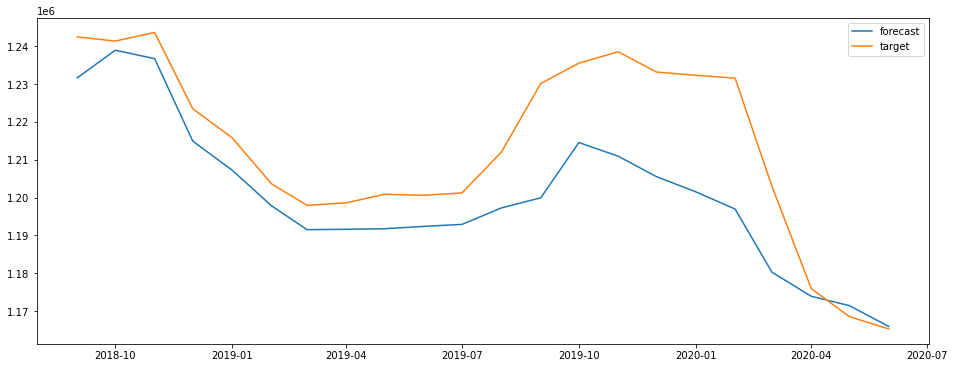

In [358]:
model_sarimax = sarimax.fit()

previsao_sarimax = model_sarimax.forecast(len(teste), exog=ibc_teste.indice_ajus.values.reshape(-1, 1))

plt.figure(figsize=(16, 6))
plt.plot(previsao_sarimax, label = 'forecast')
plt.plot(teste.estoques, label = 'target')
plt.legend()
plt.show()

### Avaliação

De toda série de TESTE

In [359]:
sqrt(mse(teste.loc['2020-01-01':].estoques, previsao_sarimax.loc['2020-01-01':]))

21103.677575563765

In [360]:
mae(teste.estoques, previsao_sarimax)

13496.65234050342

Pós 2020

In [361]:
sqrt(mse(teste.loc['2020-01-01':].estoques, previsao_sarimax.loc['2020-01-01':]))

21103.677575563765

In [362]:
mae(teste.loc['2020-01-01':].estoques, previsao_sarimax.loc['2020-01-01':])

15605.95605606834

### Predições

In [363]:
sarimax_pred = SARIMAX(
    endog=treino['estoques'], exog=ibc_treino.indice_ajus, order=arima_params, seasonal_order=(sarima_params),
    enforce_stationarity=False, enforce_invertibility=False, freq='MS')

model_sarimax_pred = sarimax_pred.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [364]:
model_sarimax_pred = sarimax_pred.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [365]:
ibc_treino[-28:].indice_ajus.values.reshape(-1, 1).shape

(28, 1)

In [366]:
fcast_ibc = model_sarimax_pred.predict(
      len(estoque_pe) - 7, 
      len(estoque_pe) + 5,
      exog=ibc_treino[-28:].indice_ajus.values.reshape(-1, 1)).rename('Forecast')

In [367]:
fcast_ibc.diff()

2019-12-01             NaN
2020-01-01    -3993.571531
2020-02-01    -4654.255955
2020-03-01   -15239.974953
2020-04-01    -3865.869015
2020-05-01    -3456.445602
2020-06-01    -7095.185026
2020-07-01    -4874.252383
2020-08-01     5942.832633
2020-09-01    -6067.869594
2020-10-01     9782.724119
2020-11-01   -10367.641699
2020-12-01   -22112.742595
Freq: MS, Name: Forecast, dtype: float64

In [369]:
fcast_ibc.loc['2020-06-01':].diff().sum()

-27696.949518796988

In [377]:
f = model_sarima_pred.get_forecast(5)
print('Forecast:')
print(f.predicted_mean)
print('Confidence intervals:')
print(f.conf_int())

Forecast:
2020-07-01    1.158784e+06
2020-08-01    1.169115e+06
2020-09-01    1.184759e+06
2020-10-01    1.181844e+06
2020-11-01    1.181171e+06
Freq: MS, dtype: float64
Confidence intervals:
            lower estoques  upper estoques
2020-07-01    1.125934e+06    1.191633e+06
2020-08-01    1.110576e+06    1.227654e+06
2020-09-01    1.091864e+06    1.277654e+06
2020-10-01    1.051083e+06    1.312605e+06
2020-11-01    1.007895e+06    1.354446e+06


In [378]:
f.predicted_mean.diff()

2020-07-01             NaN
2020-08-01    10331.548728
2020-09-01    15644.040003
2020-10-01    -2914.758798
2020-11-01     -673.887437
Freq: MS, dtype: float64